# SURE 2025 Speedy Simulations Kickoff
## Better Low Discrepancy Sequences

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### If are running this notebook in on colab, replace False in the next cell by True
### If you running this in Jupyter notebook and you have the environment set up, ignore the cell below

In [57]:
if False:  #Running on colab? # If you are running this on colab
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install qmcpy

### Import needed packages

In [92]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly
$$
x_i = i/n, \qquad i = 0, \ldots, n-1
$$

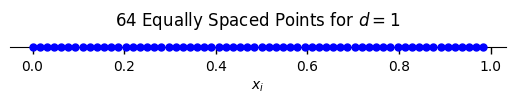

In [77]:
n = 64
xpts = np.linspace(0, 1-1./n, n) #equally spaced points between 0 and 1
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), 'b.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.tick_params(axis='both', which='major', length=5, width=1)
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

## Grids in dimension $d > 1$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [88]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(0, 1.0-1/nper, nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

pad = 0.05
def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = '', axis_pad = pad, imgfrmt = 'pdf'):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0-axis_pad,1+axis_pad])
    ax.set_ylim([0-axis_pad,1+axis_pad])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


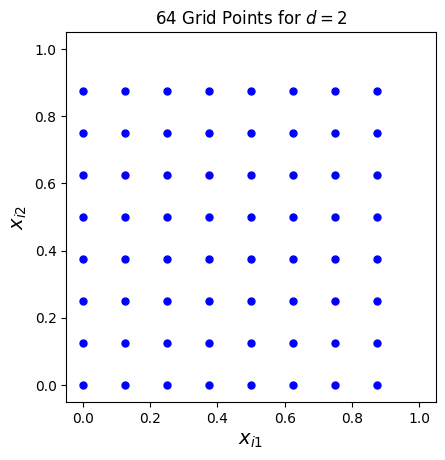

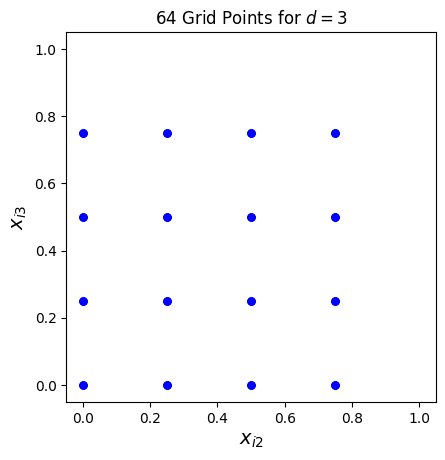

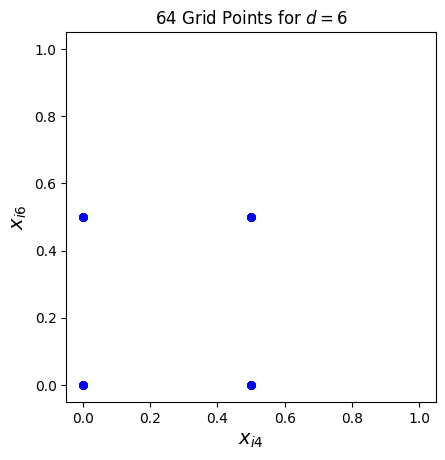

In [79]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

## Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

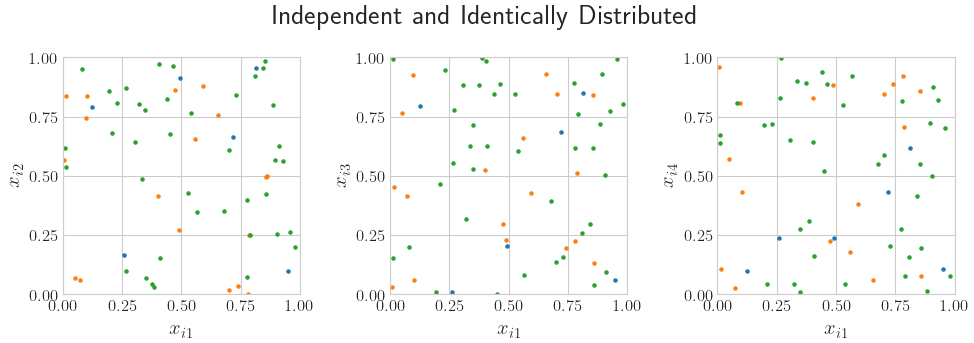

In [ ]:
d = 6  #the dimension used for these examples
n_list = [6, 24, 64]  #the sample size used for these examples
nn = len(n_list)  #the number of sample sizes
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n_list, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10,where_title = 0.55,fig_title = 'Independent and Identically Distributed')
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Low disrepancy sequences
There are several kinds of low discrepancy points, includng Sobol', lattice, Halton, and Kronecker.

## 1-dimensional low disrepancy sequences
We start with a one dimensional **extensible** sequence:
\begin{equation*}
\begin{aligned}
\textsf{van der Corput sequence} \quad & \phi_b((\cdots i_2 i_1 i_0)_b) = {}_b (0. i_0 i_1 i_2 \cdots) \\
\textsf{e.g. } & \phi_2(6) = \phi_2(110_2) = {}_2 0. 011 = 3/8
\end{aligned}
\end{equation*}
We and add a shift as well:
\begin{equation*}
x_i = \phi_b(i) + \Delta \bmod 1, \qquad i = 0, 1, 2, \ldots
\end{equation*}

Below we display one kind.

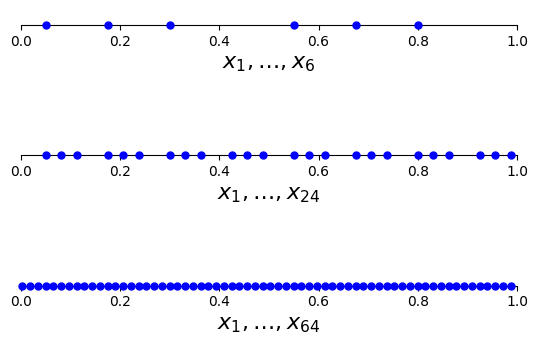

In [ ]:
delta = 0.05  #the spacing between the points
xpts = np.mod(qp.DigitalNetB2(dimension=1,randomize=False).gen_samples(n_max=n_list[-1],warn=False) + delta,1) #generate a van de Corput sequence and add a shift
plt.style.use('default')
fig, ax = plt.subplots(nn)
for ii in range(nn):
    n = n_vec[ii]
    ax[ii].plot(xpts[:n], np.zeros_like(xpts[:n]), 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax[ii].set_ylim([0, 3e-2])
    ax[ii].set_xlim([0, 1])
    #ax[ii].set_title(f"{n:.0f} Van de Corput Points for $d=1$")
    ax[ii].set_xlabel(f"$x_1, \ldots, x_{{{n:.0f}}}$", fontsize=16)
    ax[ii].set_aspect(1)
    ax[ii].axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
    ax[ii].spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}VDCpts."+imgfrmt,format=imgfrmt)

### $d$-Dimensional integration lattices with a shift

\begin{equation*}
\boldsymbol{x}_i = \phi_b(i) \boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}


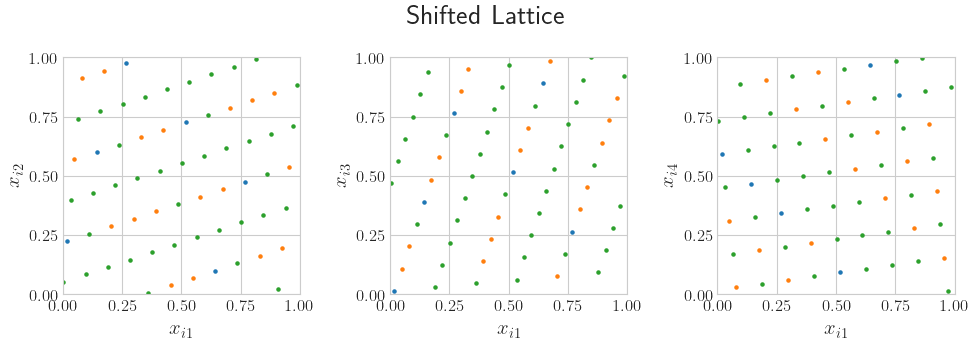

In [87]:
fig,ax = qp.plot_proj(qp.Lattice(d), n=n_vec, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10,where_title = 0.55,fig_title = 'Shifted Lattice')
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}lattice_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Kronecker sequence with a shift

\begin{equation*}
\boldsymbol{x}_i = i \boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}

In [93]:
x_kronecker = qp.kronecker(n, d, alpha = np.random.rand(d), delta = np.random.rand(d))  #generate the samples
fig,ax = plt.subplots(nn)
for ii in range(nn):
    n_start = 0 if ii == 0 else n_list[ii-1]  #the starting index for the samples
    n = n_list[ii]
    ax[ii].plot(x_kronecker[:n,0], x_kronecker[n_start:n,1], '.', markersize = 10, zorder=10, clip_on=False)  
    ax[ii].set_axis('equal')  #set the aspect ratio to be equal
    ax[ii].set_xlim([0-axis_pad,1+axis_pad])
    ax[ii].set_ylim([0-axis_pad,1+axis_pad])   
   
plt.suptitle(f"{n:.0f} Kronecker Points")
if savefigs:
        fig.savefig(figpath+f"{n:.0f}lattice_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

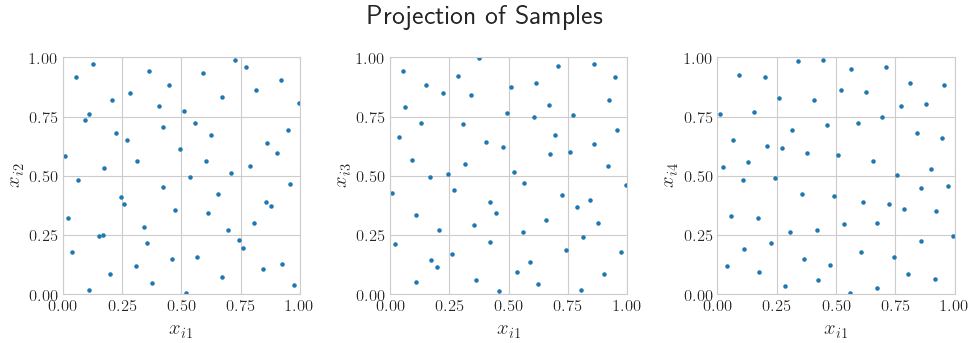

In [86]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10,where_title = 0.55)
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional integration lattices with a shift

\begin{equation*}
\boldsymbol{x}_i = \phi_b(i) \boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}
